# Détectez les Bad Buzz grâce au Deep Learning

### Déscriptif projet

<a href="https://openclassrooms.com/fr/paths/188-ingenieur-ia" target="_blank" style="text-decoration: none; text-align:center;">
    
<img src="./Air_Paradis_Logo.png" style="display:inline-block;max-height: 5rem; max-width: 100%;">
</a>


La société "Air Paradis" souhaite pouvoir détecter les bad buzz via le réseau Twitter. 
Elle souhaite pouvoir détecter les sentiments à partir de jeux de données textuels (Prototype à créer)


Jeu de données: Kaggle : <a href="https://www.kaggle.com/kazanova/sentiment140" target="_blank"> "Sentiment140 dataset with 1.6 miilion tweets"</a> 
 - 1.600.000 tweets labellisés avec un sentiment (négatif ou positif). 
 - Génerer plusieurs solutions: Azure, Custom, ...

6 Champs du fichiers: 

    **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
    **id**: The id of the tweet ( 2087)
    **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
    **flag*: The query (lyx). If there is no query, then this value is NO_QUERY.
    **user**: the user that tweeted (robotickilldozr)
    **text**: the text of the tweet (Lyx is cool)

Pour détecter la severité d'un tweet, [cet article](https://www.linkedin.com/pulse/social-machine-learning-h2o-twitter-python-marios-michailidis/) peut s'avérer intérressant.


TO-DO :
 - Préparer 2 prototypes fonctionnels de modèles : Envoie d'un tweet et récupération de la prédiction de sentiment
     - “Modèle sur mesure simple”. (ex : régression logistique).
     - “Modèle sur mesure avancé”. (ex : Réseaux de neurones profonds). ==> Modèle à déployer
 - Préparer un support de présentation explicitant la méthodologie utilisée pour l’approche “modèle sur mesure avancé” (attention : audience non technique).
     - 2 techniques de prétraitement du texte ont été testées (ex : lemmatization, stemming…), pour améliorer les performances du modèle de Deep Learning.
     - 2 méthodes de plongement de mots ont été testées (word2vec, Glove, fasttext…), pour améliorer les performances du modèle de Deep Learning.
     - Choix de la métrique adaptée à la problématique métier.
     
 - Note: Essayer au moins deux word embeddings différents et garder celui qui permet d’obtenir les meilleures performances.
 - Note: Regarder l’apport en performance d’un modèle BERT

Les évaluations des modèles seront faites sur des [metrics](https://scikit-learn.org/stable/modules/classes.html?highlight=metrics#module-sklearn.metrics) provenant de la librairies SickitLearn, tels que:
 - [F1 score](https://en.wikipedia.org/wiki/F1_score)
 - Recall
 - Precision
 - Accuracy
 - [ROC_AUC](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it)
 
Nous adapterons les hyperparamètres des modèles d'apprentissage, afin de visualiser les variations des scores.
Nous travaillerons sur [l'équilibrage des classes](http://xgboost.readthedocs.io/en/latest/parameter.html), ainsi que sur le seuil de décisions afin de visualiser les variations des résultats du Recall et du F1_Score.


In [34]:
import numpy as np
import pandas as pd
from pandas.plotting import parallel_coordinates
from pandas import json_normalize


%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
sns.set_theme()

import plotly.express as px
import tarfile
import json
import csv
import random
import time
import re

#Import functions createdon my side
from Functions_custo_by_Nico import * 

from joblib import dump, load
import pickle

# Import custom helper libraries
import os
#from os import listdir, path
#from os.path import isfile, join, splitext

import sys
#import data.helpers as data_helpers
#import visualization.helpers as viz_helpers

src_path = os.path.abspath(os.path.join("../IA_Project7_Openclassrooms_BadBuzz_DeepLearning"))
if src_path not in sys.path:
    sys.path.append(src_path)
    
import preprocessor as p

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag, pos_tag_sents
from nltk.tag.util import str2tuple


import sklearn
from sklearn import cluster, metrics, preprocessing, manifold, decomposition, kernel_ridge, linear_model, svm
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, confusion_matrix, ConfusionMatrixDisplay, fbeta_score, precision_recall_curve, make_scorer, plot_roc_curve, mean_squared_error
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve, cross_val_score, KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVR
from sklearn.utils.class_weight import compute_sample_weight


from PIL import Image

## Exploration des données
### Lecture du fichier

In [35]:
# calling functions
Test_Imported_Functions()

Functions have been properly imported !


In [36]:
# Load data from CSV
DATA_URL = os.path.join(src_path, "Dataset", "sentiment140", "training.1600000.processed.noemoticon.csv")
DATASET_COLUMNS = ["target", "id", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
SENTIMENT_MAP = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}

#nrows = 3000



# Using Function load_data = pd.read_csv(DATA_URL, nrows=nrows, names=columns)
df = load_formatted_data(DATA_URL, DATASET_ENCODING, DATASET_COLUMNS) #load_data(DATA_URL, nrows, columns)
df["target_string"] = df["target"].map(lambda x: SENTIMENT_MAP[x])
df["date_format"] = pd.to_datetime(df['date'], format="%a %b %d %H:%M:%S PDT %Y")
df.head()

,target,id,date,flag,user,text,target_string,date_format
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",NEGATIVE,2009-04-06 22:19:45
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,NEGATIVE,2009-04-06 22:19:49
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,NEGATIVE,2009-04-06 22:19:53
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,NEGATIVE,2009-04-06 22:19:57
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",NEGATIVE,2009-04-06 22:19:57


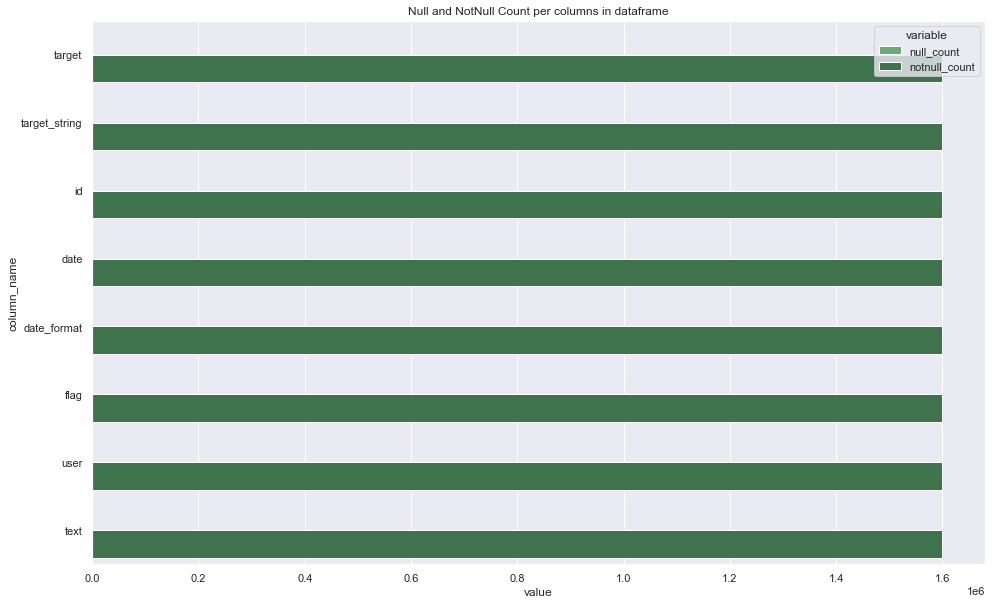

,column_name,null_count,notnull_count
0,target,0,1600000
0,target_string,0,1600000
0,id,0,1600000
0,date,0,1600000
0,date_format,0,1600000
0,flag,0,1600000
0,user,0,1600000
0,text,0,1600000


In [37]:
DATASET_COLUMNS = ["target", "target_string", "id", "date", "date_format", "flag", "user", "text"]
plot_fill_ratio(df, DATASET_COLUMNS)

### Nettoyage du jeu de données

Ici, le nettoyage consiste à :
 - Supprimer les lignes manquantes (Non-applicable dans notre cas)
 - Supprimer les dupliquées (Non-applicable dans notre cas)
 - Passer les champs "Object" en minuscule
 - Remplacer les valeurs Target = 4, à une valeur binaire = 1
 

<div class="alert alert-block alert-info"><b>
    Tip:
    </b> 
    Attention !!! Dans la cellule ci-dessous, nous reduisons le jeu de donnée à des fins de performance lors de la phase de développement.
</div>


In [38]:
### REDUCTION DU JEU DE DONNEE POUR LES PHASES DE TESTS
clean_df = df.sample(frac=0.2, random_state=0)
#clean_df = clean_data(df.groupby('target').apply(lambda x: x.sample(frac=0.08))) #clean_data(df)


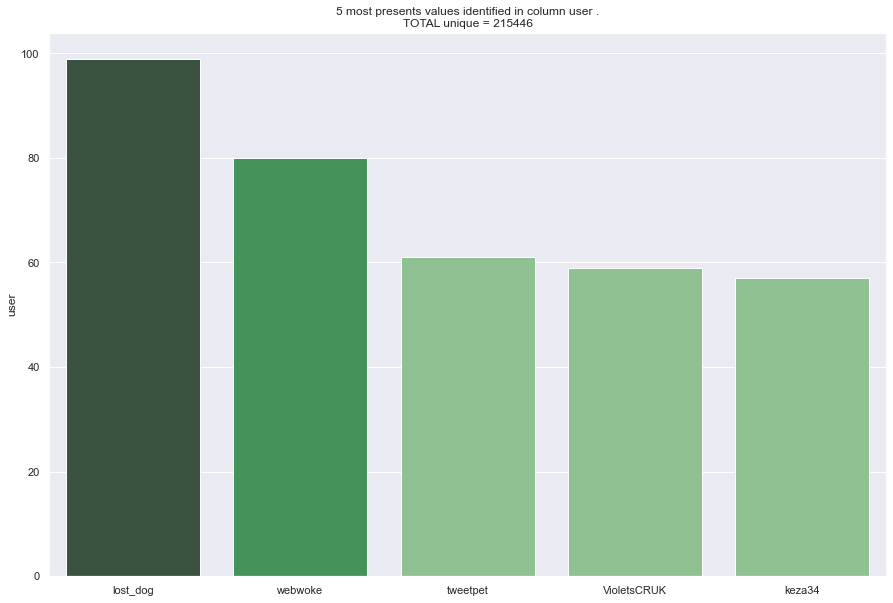

,user
lost_dog,99
webwoke,80
tweetpet,61
VioletsCRUK,59
keza34,57


In [39]:
ntops = 5
plot_ntops_bar(clean_df, "user", ntops, False, False)

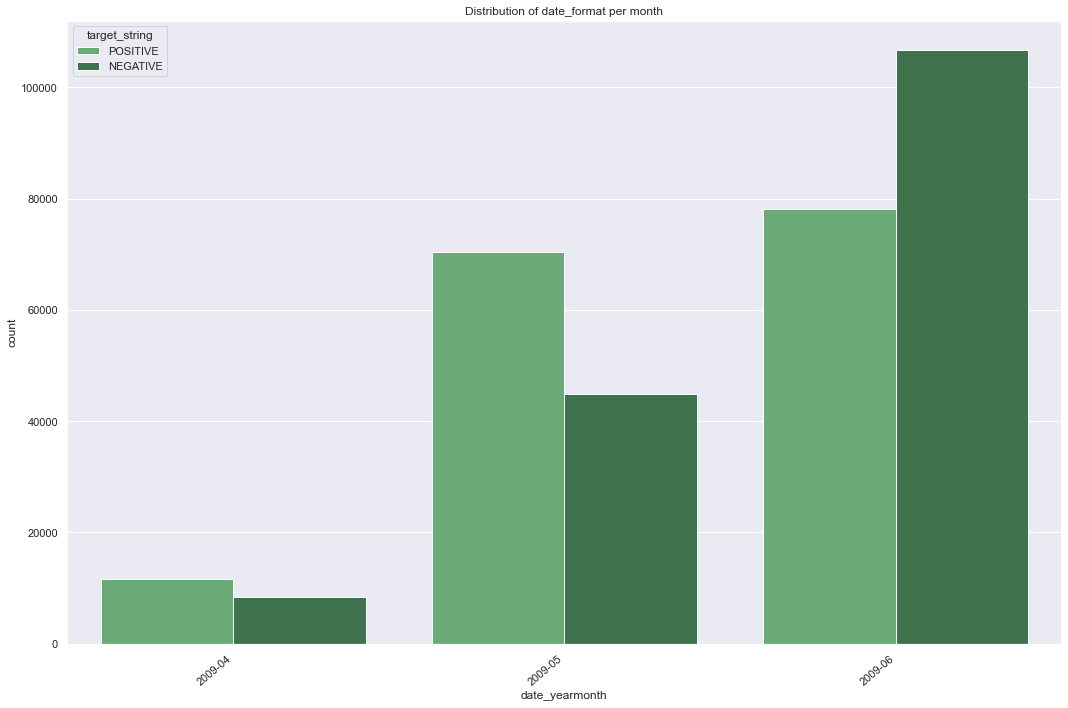

In [40]:
plot_peryearmonth(clean_df, "date_format", True, "target_string")

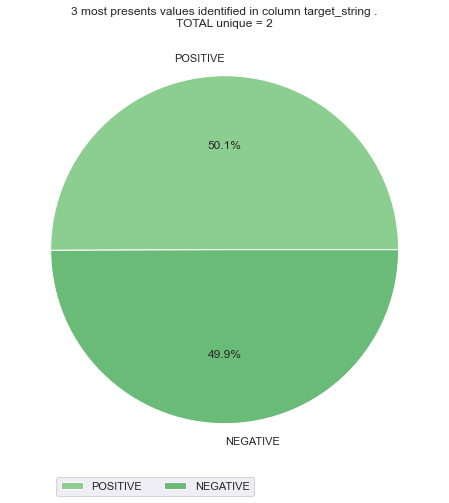

,target_string
POSITIVE,160185
NEGATIVE,159815


In [41]:
ntops = 3
sns.set_palette("Greens_d")
plot_ntops_pie(clean_df, "target_string", ntops, False, False)

In [42]:
clean_df = clean_df.drop(['id', 'date', 'flag', 'user', 'target_string', 'date_format', 'date_yearmonth'], axis=1)
clean_df.head(3)

,target,text
557138,0,wants to compete! i want hard competition! i w...
349381,0,It seems we are stuck on the ground in Amarill...
182051,0,where the f are my pinking shears? rarararrrar...


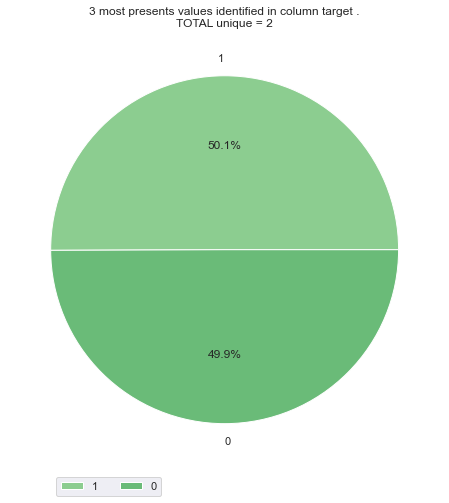

,target
1,160185
0,159815


In [43]:
#Replace Target value related to positive statement = 1 (Binary reason)
#clean_df['target'] = clean_df['target'].map({4: 1, 0: 0})
clean_df.loc[clean_df['target'] == 4, 'target'] = 1
plot_ntops_pie(clean_df, "target", ntops, False, False)

### Nettoyage des données Textuelles

In [44]:
#Create columns where only words not in stopwords are kept
clean_df["text_stopwords"] = clean_df.text.apply(lambda x: text_preprocess(x, True, False, False))

#Create columns where text is lemmatized 
clean_df["text_lem"] = clean_df.text.apply(lambda x: text_preprocess(x, True, False, True))

#Create columns where text is stemmatized
clean_df["text_stem"] = clean_df.text.apply(lambda x: text_preprocess(x, True, True, False))

#Text preprocess using https://pypi.org/project/tweet-preprocessor/
clean_df.text = clean_df.text.apply(lambda x: p.clean(x)) #Optional : Library tweet preprocessor specifically adapted for business needs


### Conclusion suite à l'exploration des données.
Le nombre de tweets extrait est de 1.600.000, et il apparait parfaitement équilibré
 - 50% Positifs
 - 50% Négatifs
 
Les dates des tweets se situent sur une durée courte, de 3 mois.

Le jeu de données ne contient pas de valeurs nulles.

## Traitement des données
### Séparation des jeux de données Train, Val et Test

In [45]:
#STOPWORDS TEXT
#Define 20% of dataset as Test dataset
X_train, X_test, y_train, y_test = train_test_split(clean_df['text'], clean_df['target'], test_size=0.2, random_state=0, stratify=clean_df['target'])
#Define 20% (=25% * 80%) of dataset as Val dataset, and 60% as Train dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0, stratify=y_train)


#STOPWORDS TEXT
#Define 20% of dataset as Test dataset
X_train_stopwords, X_test_stopwords, y_train_stopwords, y_test_stopwords = train_test_split(clean_df['text_stopwords'], clean_df['target'], test_size=0.2, random_state=0, stratify=clean_df['target'])
#Define 20% (=25% * 80%) of dataset as Val dataset, and 60% as Train dataset
X_train_stopwords, X_val_stopwords, y_train_stopwords, y_val_stopwords = train_test_split(X_train_stopwords, y_train_stopwords, test_size=0.25, random_state=0, stratify=y_train_stopwords)


#LEM TEXT
#Define 20% of dataset as Test dataset
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(clean_df['text_lem'], clean_df['target'], test_size=0.2, random_state=0, stratify=clean_df['target'])
#Define 20% (=25% * 80%) of dataset as Val dataset, and 60% as Train dataset
X_train_lem, X_val_lem, y_train_lem, y_val_lem = train_test_split(X_train_lem, y_train_lem, test_size=0.25, random_state=0, stratify=y_train_lem)


#STEM TEXT
#Define 20% of dataset as Test dataset
X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(clean_df['text_stem'], clean_df['target'], test_size=0.2, random_state=0, stratify=clean_df['target'])
#Define 20% (=25% * 80%) of dataset as Val dataset, and 60% as Train dataset
X_train_stem, X_val_stem, y_train_stem, y_val_stem = train_test_split(X_train_stem, y_train_stem, test_size=0.25, random_state=0, stratify=y_train_stem)

### Extraire les informations du texte
#### Bag of Words
La technique Bag of Words consiste à représenter le document par un ensemble des mots qu'il contient. En pratique, ça peut être par exemple un vecteur de fréquence d'apparition des différents mots utilisés.

Voir [exemple ci-dessous](https://openclassrooms.com/fr/courses/6532301-introduction-to-natural-language-processing/6980811-apply-a-simple-bag-of-words-approach#/id/r-7053954)

Généralement, il faut aller au delà de la tokenisation, afin de séparer le texte en groupes de plusieurs mots. On appelle les groupes de mots les n-grammes (n-gram) : 
 - [bigrammes](https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/4855001-representez-votre-corpus-en-bag-of-words#/id/r-4855203) pour les couples de mots
 - trigrammes pour les groupes de 3
 - etc. 
 - Séparer en mot unique est en fait un cas particulier appelé unigrammes.

L'utilisation de la fonction [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) permettra de retourner la matrice de comptage des tokens.
    
Cependant, l'inconvenient de cette technique est qu'il utilise uniquement la fréquence d'apparition des mots (voir [Matrice creuses](https://openclassrooms.com/fr/courses/4470541-analysez-vos-donnees-textuelles/4855001-representez-votre-corpus-en-bag-of-words#/id/r-5174008)). 
Or, si l'on veut représenter les documents dans leur ensemble, nous devons considérer la rareté, et la siungularité du mot.


#### Encodage du texte avec TF-IDF
 
Nous avons d'abord supprimé les mots les plus fréquents de manière générale dans le langage (les fameux stopwords). À présent, il ne faut pas considérer le poids d'un mot dans un document comme sa fréquence d'apparition uniquement, mais pondérer cette fréquence par un indicateur si ce mot est commun ou rare dans tous les documents.

Pour résumer, le poids du n-gramme est le suivant :

    poids=fréquence du terme×indicateur similarité

En l’occurence, la métrique tf-idf (Term-Frequency - Inverse Document Frequency) utilise comme indicateur de similarité l'inverse document frequency qui est l'inverse de la proportion de document qui contient le terme, à l'échelle logarithmique. Il est appelé logiquement « inverse document frequency » (idf). 

Nous calculons donc le poids tf-idf final attribué au n-gramme :

    poids=frequence du n-gram×idf(n-gramme)

In [46]:
#Nous entrainons les Vectorisers, en fonction des différents jeux d'entrainements.
#For cleaned text using preprocessor
vectoriser = TfidfVectorizer(min_df=0.005,max_df=0.8) #TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'vectoriser_stopwords entrainé, et le nombre de feature est de {len(vectoriser.get_feature_names_out())}')

#Nous construisons les Bag Of Words, en fonctions des jeux de données Train, Val, Test
#For cleaned text using preprocessor
X_train = vectoriser.transform(X_train)
X_val = vectoriser.transform(X_val)
X_test  = vectoriser.transform(X_test)
print("La Matrice TF-IDF normalisée %d X %d à partir du text X_train" % (X_train.shape[0], X_train.shape[1]) )
print("La Matrice TF-IDF normalisée %d X %d à partir du text X_val" % (X_val.shape[0], X_val.shape[1]) )
print("La Matrice TF-IDF normalisée %d X %d à partir du text X_test" % (X_test.shape[0], X_test.shape[1]) )


vectoriser_stopwords entrainé, et le nombre de feature est de 325
La Matrice TF-IDF normalisée 192000 X 325 à partir du text X_train
La Matrice TF-IDF normalisée 64000 X 325 à partir du text X_val
La Matrice TF-IDF normalisée 64000 X 325 à partir du text X_test


In [47]:
#Nous entrainons les Vectorisers, en fonction des différents jeux d'entrainements.
#For STOPWORDS
vectoriser_stopwords = TfidfVectorizer(min_df=0.005,max_df=0.8) #TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser_stopwords.fit(X_train_stopwords)
print(f'vectoriser_stopwords entrainé, et le nombre de feature est de {len(vectoriser_stopwords.get_feature_names_out())}')

#Nous construisons les Bag Of Words, en fonctions des jeux de données Train, Val, Test
#For STOPWORDS
X_train_stopwords = vectoriser_stopwords.transform(X_train_stopwords)
X_val_stopwords = vectoriser_stopwords.transform(X_val_stopwords)
X_test_stopwords  = vectoriser_stopwords.transform(X_test_stopwords)
print("La Matrice TF-IDF normalisée %d X %d à partir du text X_train_stopwords" % (X_train_stopwords.shape[0], X_train_stopwords.shape[1]) )
print("La Matrice TF-IDF normalisée %d X %d à partir du text X_val_stopwords" % (X_val_stopwords.shape[0], X_val_stopwords.shape[1]) )
print("La Matrice TF-IDF normalisée %d X %d à partir du text X_test_stopwords" % (X_test_stopwords.shape[0], X_test_stopwords.shape[1]) )


vectoriser_stopwords entrainé, et le nombre de feature est de 223
La Matrice TF-IDF normalisée 192000 X 223 à partir du text X_train_stopwords
La Matrice TF-IDF normalisée 64000 X 223 à partir du text X_val_stopwords
La Matrice TF-IDF normalisée 64000 X 223 à partir du text X_test_stopwords


In [48]:
#Nous entrainons les Vectorisers, en fonction des différents jeux d'entrainements.
#For LEM TEXT
vectoriser_lem = TfidfVectorizer(min_df=0.005,max_df=0.8) #TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser_lem.fit(X_train_lem)
print(f'vectoriser_lem entrainé, et le nombre de feature est de {len(vectoriser_lem.get_feature_names_out())}')

#Nous construisons les Bag Of Words, en fonctions des jeux de données Train, Val, Test
#For LEM TEXT
X_train_lem = vectoriser_lem.transform(X_train_lem)
X_val_lem = vectoriser_lem.transform(X_val_lem)
X_test_lem  = vectoriser_lem.transform(X_test_lem)
print("La Matrice TF-IDF normalisée %d X %d à partir du text X_train_lem" % (X_train_lem.shape[0], X_train_lem.shape[1]) )
print("La Matrice TF-IDF normalisée %d X %d à partir du text X_val_lem" % (X_val_lem.shape[0], X_val_lem.shape[1]) )
print("La Matrice TF-IDF normalisée %d X %d à partir du text X_test_lem" % (X_test_lem.shape[0], X_test_lem.shape[1]) )


vectoriser_lem entrainé, et le nombre de feature est de 226
La Matrice TF-IDF normalisée 192000 X 226 à partir du text X_train_lem
La Matrice TF-IDF normalisée 64000 X 226 à partir du text X_val_lem
La Matrice TF-IDF normalisée 64000 X 226 à partir du text X_test_lem


In [49]:
#For STEM TEXT
vectoriser_stem = TfidfVectorizer(min_df=0.005,max_df=0.8) #TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser_stem.fit(X_train_stem)
print(f'vectoriser_stem entrainé, et le nombre de feature est de {len(vectoriser_stem.get_feature_names_out())}')


#For STEM TEXT
X_train_stem = vectoriser_stem.transform(X_train_stem)
X_val_stem = vectoriser_stem.transform(X_val_stem)
X_test_stem  = vectoriser_stem.transform(X_test_stem)
print("La Matrice TF-IDF normalisée %d X %d à partir du text X_train_stem" % (X_train_stem.shape[0], X_train_stem.shape[1]) )
print("La Matrice TF-IDF normalisée %d X %d à partir du text X_val_stem" % (X_val_stem.shape[0], X_val_stem.shape[1]) )
print("La Matrice TF-IDF normalisée %d X %d à partir du text X_test_stem" % (X_test_stem.shape[0], X_test_stem.shape[1]) )



vectoriser_stem entrainé, et le nombre de feature est de 239
La Matrice TF-IDF normalisée 192000 X 239 à partir du text X_train_stem
La Matrice TF-IDF normalisée 64000 X 239 à partir du text X_val_stem
La Matrice TF-IDF normalisée 64000 X 239 à partir du text X_test_stem


## Construction des Modèles de Machine Learning

Dans cette partie, nous allons tout d'abord créer un modèle Naïve, pour lequel nous regarderons les performances sur X_test_std:
   - roc auc
   - precision : $\frac{TP}{TP + FP}$
   - accuracy : $\frac{TP + TN}{Total}$
   - recall : $\frac{TP}{TP + FN}$
   - f1 score : $\frac{2TP}{2TP + FP + FN} = \frac{2 * precision * recall}{precision + recall}$
   
Au regard de la matrice de confusion, l'objectif sera de maximiser l'accuracy. 

A ce titre, nous ajouterons une métrique appelée la F_Mesure ou **FBeta score** (comme [expliqué ici](https://openclassrooms.com/fr/courses/4297211-evaluez-les-performances-dun-modele-de-machine-learning/4308256-evaluez-un-algorithme-de-classification-qui-retourne-des-valeurs-binaires#/id/r-4337570))
   - FBeta score : ($F_{\beta}$) : $F_{\beta} = (1 + \beta^{2}) \frac{precision * recall}{\beta^{2} * precision + recall}$ 


Cette mesure du [FBeta-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html), nous permettra d'afficher un compromis entre la précision du modèle et le rappel.
Note: *_La valeur optimale du FBeta score est 1, et la pire valeur est 0._*
Le Fbeta-score augmente ou diminue le poids du rappel grâce au paramètre "beta"
   - Si beta < 1: Plus de poid accordé à la précision
   - Si beta > 1: Plus de poid accordé au rappel  
   - Dans notre cas : beta = 0.5 : L'importance de la précision est augmenté pour diminuer le nombre de Faux positifs
     
*fbeta_score(y_true, y_pred, average='binary', beta=0.5)*


In [50]:
#Initialisation de la table des résultats
score_column_names = ["Model Type","Model Name","seuil","F1-Score","FBeta-Score", "Recall_score", "Precision_score", "Accuracy_score", "Roc_AUC_score"]
store_score = pd.DataFrame(columns = score_column_names)

In [51]:
# def plot_roc_curve(model_name, fpr, tpr, figsize=(5,5)):
#     plt.figure(figsize=figsize)
#     plt.title(f"ROC Curve for {model_name}")
#     plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#     plt.plot(fpr, tpr, marker='.', label=model_name)
#     # axis labels
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.legend()
#     # show the plot
#     plt.show()

# #Fonction pour le graphe de Matrice de Confusion
# def matrix_pred_model(model, model_name, y_test, y_pred, figsize=(5,5)):
#     plt.figure(figsize=figsize)
#     plt.title(f"Matrice de confusion de {model_name}")
#     sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap = 'Greens',fmt="d",cbar=False)
#     plt.xlabel("Classe prédite")
#     plt.ylabel("Classe initiale")
#     plt.show()
    
# def evaluation(model,model_name,score_column_names,X_test,y_test, seuil = 0.5):
#     #Si le seuil n'est pas important
#     y_pred = model.predict(X_test)
#     y_prob = model.predict_proba(X_test)[:,1]
    
#     F1_score = f1_score(y_test, y_pred) #, pos_label=4
#     Recall_score = recall_score(y_test, y_pred) #, pos_label=4
#     Precision_score = precision_score(y_test, y_pred) #, pos_label=4
#     Accuracy_score = accuracy_score(y_test, y_pred)

#     # On créé un vecteur de prédiction à partir du vecteur de probabilités
#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob) #y_pred instead of y_prob #, pos_label=4
#     Roc_AUC_score = auc(false_positive_rate, true_positive_rate)

#     #In our case, we want to increase precision, to reduce false positive (and detect more negative evaluation) = beta = 0.5
#     FBeta_score = fbeta_score(y_test, y_pred, average='binary', beta=0.5, pos_label=1)

#     #Plot functions
#     matrix_pred_model(model, model_name, y_test,y_pred) 
#     plot_roc_curve(model_name, false_positive_rate, true_positive_rate)
    
#     global store_score
#     score_results = pd.Series([model, model_name, seuil, F1_score, FBeta_score, Recall_score, Precision_score, Accuracy_score, Roc_AUC_score])
#     score_results_stored = pd.DataFrame([score_results.values],  columns = score_column_names)
#     store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)
#     return(store_score)

### Modèles supervisés (non optimisés)
#### 1. Regression Logistique

Nous utilisons ici la [régression logistique de Scikit-Learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
Nous conservons le modèle par défaut (pas de modification des [Hyperparamètres](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) pour le moment).

La syntax de la **fonction evaluation** est globalement identique: 
 1. Nous entrainons le modèle en utilisant `.fit`Nous réalisons les prédictions en utilisant 
 2. Nous réalisons les prédictions en utilisant `.predict` et/ou `.predict_proba`
 
Dans le but d'améliorer la précision, nous allons réaliser une mesure de fbeta_score avec beta = 0.5.
Ceci nous permettra par la suite de minimiser les faux-positifs

In [52]:
# def evaluation(model,model_name,score_column_names,X_test,y_test, seuil = 0.5, binary_transform=False):
#     # On récupère la prédiction de la valeur positive
#     if binary_transform == True:
#         y_prob = model.predict(X_test)
#         y_pred = y_prob
#     else:
#         y_prob = model.predict_proba(X_test)[:,1]
#         y_pred = np.where(y_prob > seuil, 1, 0)
    
#     # On créé un vecteur de prédiction à partir du vecteur de probabilités
#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob) # y_prob instead of y_prob #, pos_label=4
#     Roc_AUC_score = auc(false_positive_rate, true_positive_rate)
    
#     F1_score = f1_score(y_test, y_pred)
#     FBeta_score = fbeta_score(y_test, y_pred, average='binary', beta=0.5, pos_label=1) #make_scorer(fbeta_score, beta = 2, pos_label=0 ,average = 'binary')
#     Recall_score = recall_score(y_test, y_pred)
#     Precision_score = precision_score(y_test, y_pred)
#     Accuracy_score = accuracy_score(y_test, y_pred)

    
#     #Plot functions
#     matrix_pred_model(model, model_name, y_test, y_pred) 
#     plot_roc_auc_curve(model_name, false_positive_rate, true_positive_rate)
    
#     score_results = pd.Series([model, model_name, seuil, F1_score, FBeta_score, Recall_score, Precision_score, Accuracy_score, Roc_AUC_score])
#     score_results_stored = pd.DataFrame([score_results.values],  columns = score_column_names)
#     return(score_results_stored)

# def plot_roc_curve(model_name, fpr, tpr, figsize=(5,5)):
#     plt.figure(figsize=figsize)
#     plt.title(f"ROC Curve for {model_name}")
#     plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
#     plt.plot(fpr, tpr, marker='.', label=model_name)
#     # axis labels
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.legend()
#     # show the plot
#     plt.show()

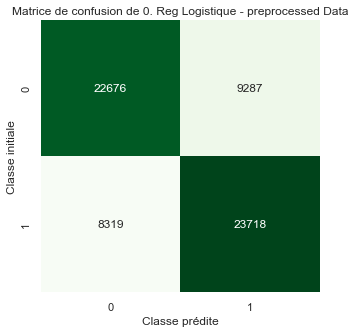

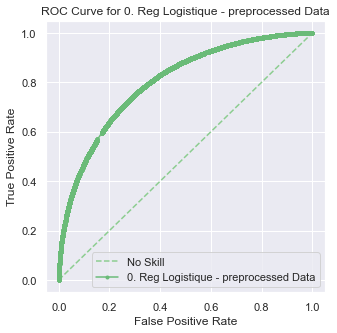

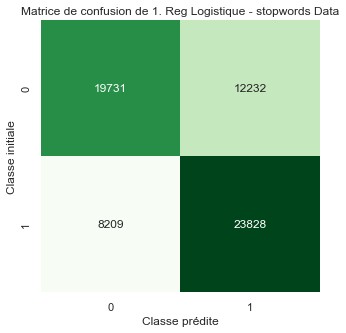

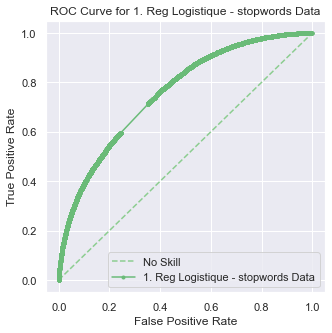

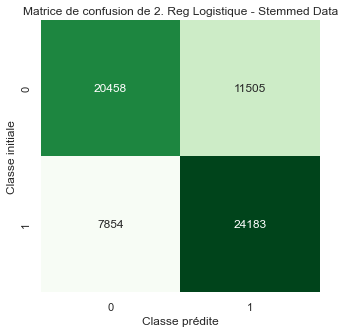

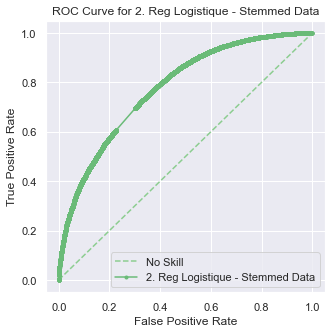

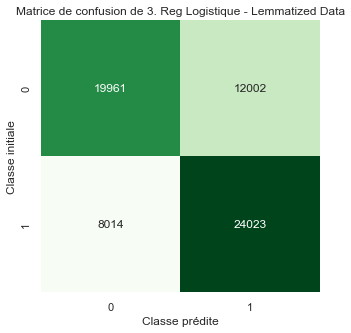

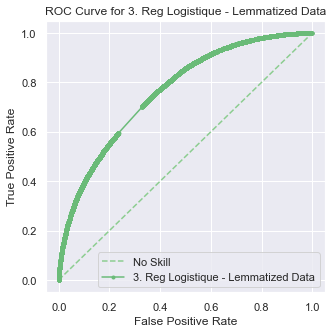

In [53]:
seuil=0.5
model_name_0="0. Reg Logistique - preprocessed Data"
logistic_reg_0 = LogisticRegression(random_state=0)
logistic_reg_0.fit(X_train, y_train)
score_results_stored = evaluation(logistic_reg_0, model_name_0, score_column_names, X_test, y_test, seuil = 0.5, binary_predict=False, predict_proba_OK=True)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)

model_name_1="1. Reg Logistique - stopwords Data"
logistic_reg_1 = LogisticRegression(random_state=0)
logistic_reg_1.fit(X_train_stopwords, y_train_stopwords)
score_results_stored = evaluation(logistic_reg_1, model_name_1, score_column_names, X_test_stopwords, y_test_stopwords, seuil = 0.5, binary_predict=False, predict_proba_OK=True)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)

model_name_2="2. Reg Logistique - Stemmed Data"
logistic_reg_2 = LogisticRegression(random_state=0)
logistic_reg_2.fit(X_train_stem, y_train_stem)
score_results_stored = evaluation(logistic_reg_2, model_name_2, score_column_names, X_test_stem, y_test_stem, seuil = 0.5, binary_predict=False, predict_proba_OK=True)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)

model_name_3="3. Reg Logistique - Lemmatized Data"
logistic_reg_3 = LogisticRegression(random_state=0)
logistic_reg_3.fit(X_train_lem, y_train_lem)
score_results_stored = evaluation(logistic_reg_3, model_name_3, score_column_names, X_test_lem, y_test_lem, seuil = 0.5, binary_predict=False, predict_proba_OK=True)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)


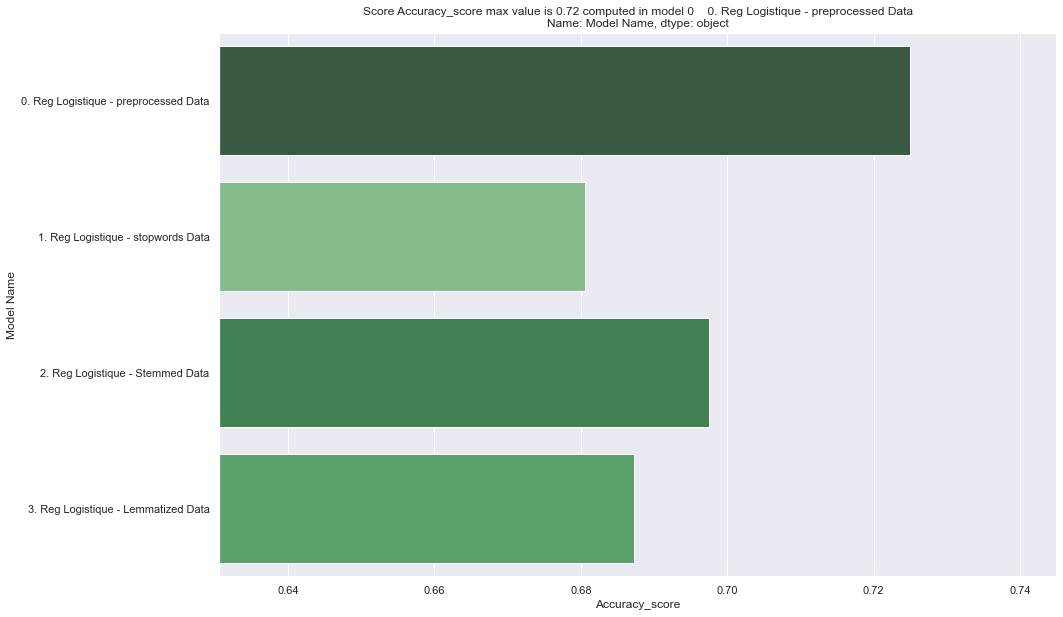

In [54]:
plot_model_result(store_score[store_score['Model Name'].str.contains("Reg Logistique")], "Accuracy_score", "Model Name")


#### 2. Decision Tree Classifiers

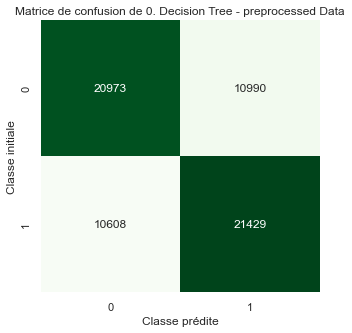

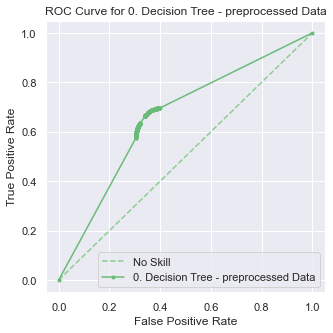

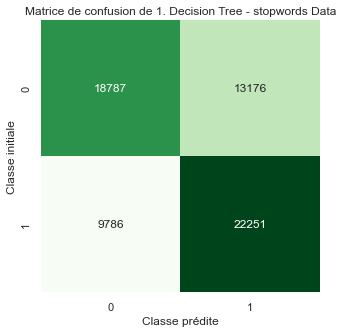

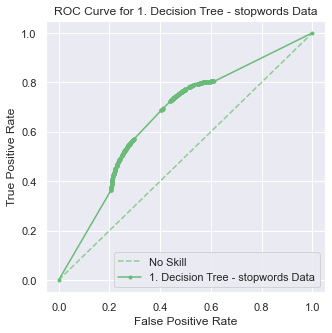

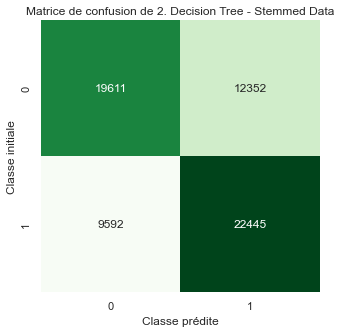

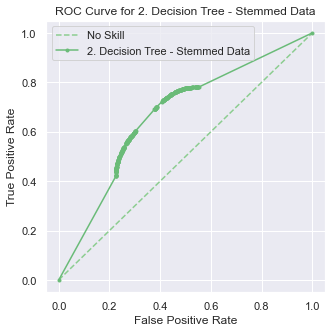

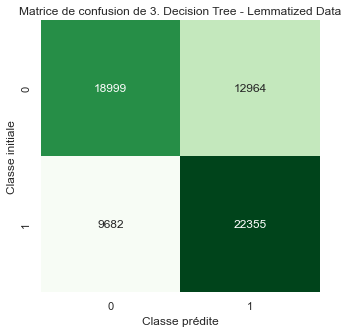

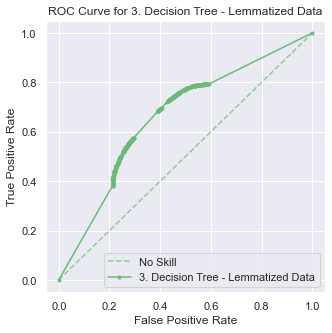

In [55]:
seuil=0.5

model_name_0="0. Decision Tree - preprocessed Data"
tree_clf_0 = DecisionTreeClassifier(random_state=0)
tree_clf_0.fit(X_train, y_train)
score_results_stored = evaluation(tree_clf_0, model_name_0, score_column_names, X_test, y_test,seuil = 0.5, binary_predict=False, predict_proba_OK=True)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)

model_name_1="1. Decision Tree - stopwords Data"
tree_clf_1 = DecisionTreeClassifier(random_state=0)
tree_clf_1.fit(X_train_stopwords, y_train_stopwords)
score_results_stored = evaluation(tree_clf_1, model_name_1, score_column_names, X_test_stopwords, y_test_stopwords,seuil = 0.5, binary_predict=False, predict_proba_OK=True)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)

model_name_2="2. Decision Tree - Stemmed Data"
tree_clf_2 = DecisionTreeClassifier(random_state=0)
tree_clf_2.fit(X_train_stem, y_train_stem)
score_results_stored = evaluation(tree_clf_2, model_name_2, score_column_names, X_test_stem, y_test_stem,seuil = 0.5, binary_predict=False, predict_proba_OK=True)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)

model_name_3="3. Decision Tree - Lemmatized Data"
tree_clf_3 = DecisionTreeClassifier(random_state=0)
tree_clf_3.fit(X_train_lem, y_train_lem)
score_results_stored = evaluation(tree_clf_3, model_name_3, score_column_names, X_test_lem, y_test_lem,seuil = 0.5, binary_predict=False, predict_proba_OK=True)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)

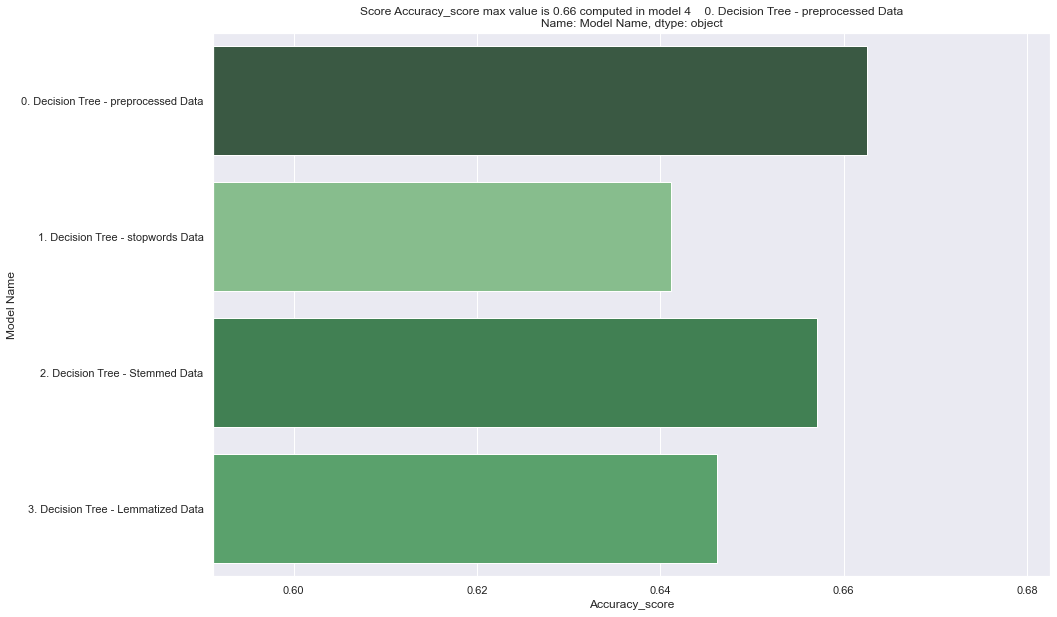

In [56]:
plot_model_result(store_score[store_score['Model Name'].str.contains("Decision Tree")], "Accuracy_score", "Model Name")


#### 3. Random Forest Classifiers
Nous essayons ici le plus performant [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforest#sklearn-ensemble-randomforestclassifier). 

Nous ne spécifierons pas ici l'utilisation du nombre d'arbres (100 est la valeur par défaut)

In [57]:
# seuil=0.5

# model_name_1="1. Random Forest - stopwords Data"
# randomforest_clf_1 = RandomForestClassifier(random_state=0)
# randomforest_clf_1.fit(X_train_stopwords, y_train_stopwords)
# evaluation(randomforest_clf_1, model_name_1, score_column_names, store_score, X_test_stopwords, y_test_stopwords,seuil = 0.5, binary_predict=False, predict_proba_OK=True)

# model_name_2="2. Random Forest - Stemmed Data"
# randomforest_clf_2 = RandomForestClassifier(random_state=0)
# randomforest_clf_2.fit(X_train_stem, y_train_stem)
# evaluation(randomforest_clf_2, model_name_2, score_column_names, store_score, X_test_stem, y_test_stem,seuil = 0.5, binary_predict=False, predict_proba_OK=True)

# model_name_3="3. Random Forest - Lemmatized Data"
# randomforest_clf_3 = RandomForestClassifier(random_state=0)
# randomforest_clf_3.fit(X_train_lem, y_train_lem)
# evaluation(randomforest_clf_3, model_name_3, score_column_names, store_score, X_test_lem, y_test_lem,seuil = 0.5, binary_predict=False, predict_proba_OK=True)

#### 4.  Gradient Boosting Classifiers

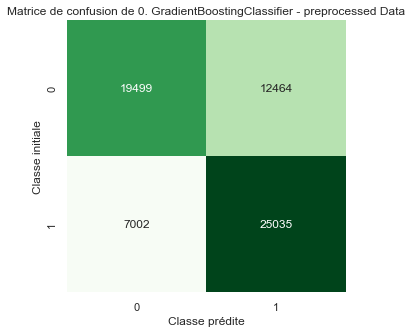

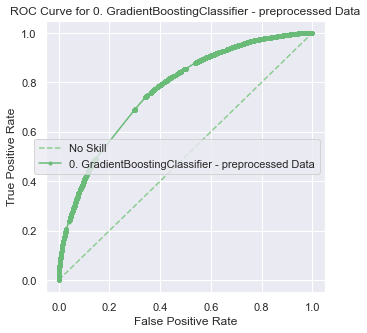

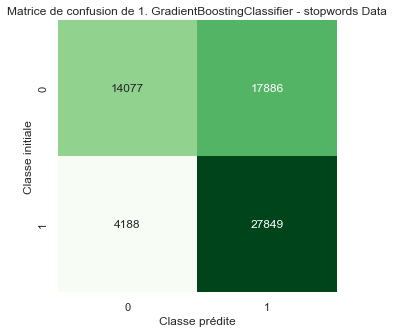

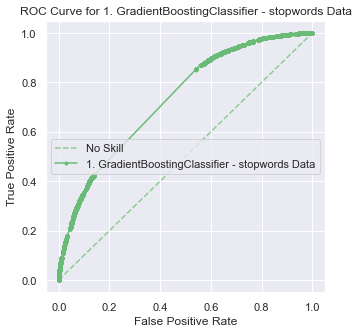

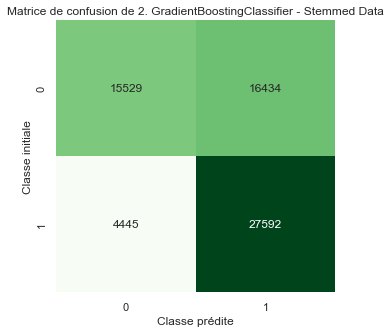

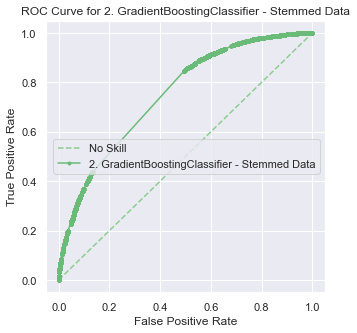

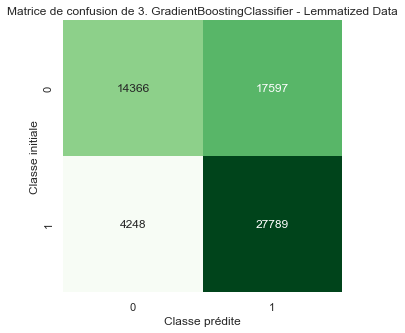

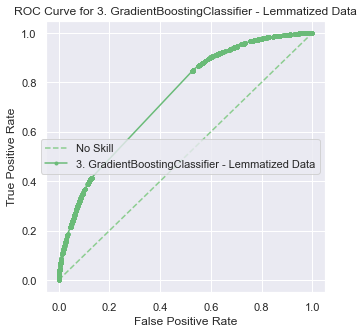

In [58]:
seuil=0.5

model_name_0="0. GradientBoostingClassifier - preprocessed Data"
GBoost_clf_0 = GradientBoostingClassifier(random_state=0)
GBoost_clf_0.fit(X_train, y_train)
score_results_stored = evaluation(GBoost_clf_0,model_name_0, score_column_names, X_test,y_test,seuil = 0.5, binary_predict=False, predict_proba_OK=True)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)

model_name_1="1. GradientBoostingClassifier - stopwords Data"
GBoost_clf_1 = GradientBoostingClassifier(random_state=0)
GBoost_clf_1.fit(X_train_stopwords, y_train_stopwords)
score_results_stored = evaluation(GBoost_clf_1,model_name_1, score_column_names, X_test_stopwords,y_test_stopwords,seuil = 0.5, binary_predict=False, predict_proba_OK=True)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)

model_name_2="2. GradientBoostingClassifier - Stemmed Data"
GBoost_clf_2 = GradientBoostingClassifier(random_state=0)
GBoost_clf_2.fit(X_train_stem, y_train_stem)
score_results_stored = evaluation(GBoost_clf_2,model_name_2, score_column_names, X_test_stem,y_test_stem,seuil = 0.5, binary_predict=False, predict_proba_OK=True)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)

model_name_3="3. GradientBoostingClassifier - Lemmatized Data"
GBoost_clf_3 = GradientBoostingClassifier(random_state=0)
GBoost_clf_3.fit(X_train_lem, y_train_lem)
score_results_stored = evaluation(GBoost_clf_3,model_name_3, score_column_names, X_test_lem,y_test_lem,seuil = 0.5, binary_predict=False, predict_proba_OK=True)
store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)


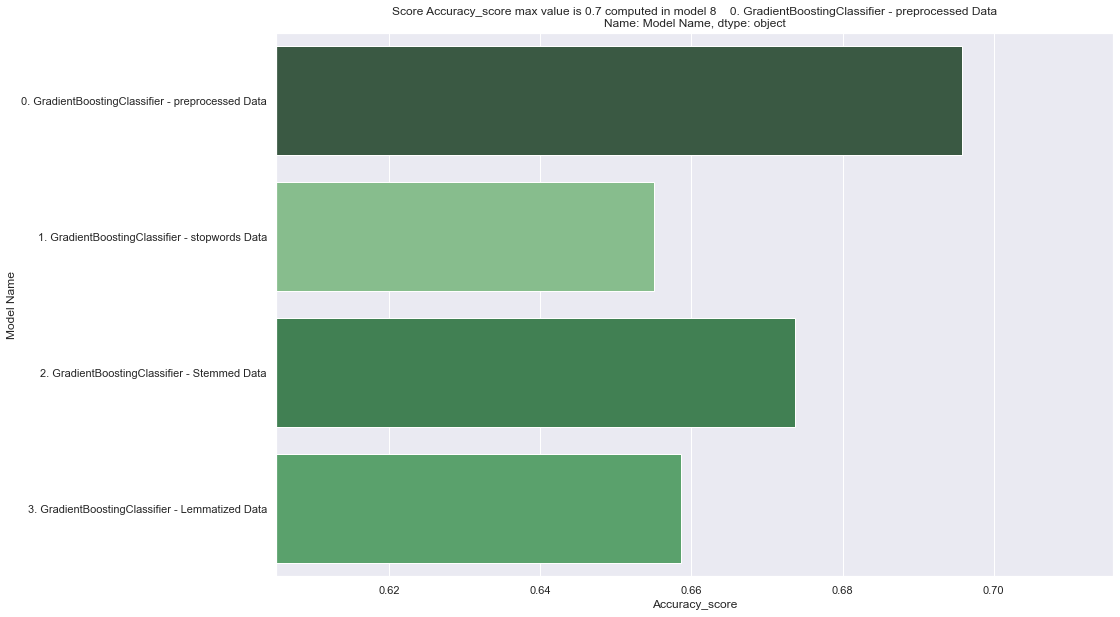

In [59]:
plot_model_result(store_score[store_score['Model Name'].str.contains("GradientBoostingClassifier")], "Accuracy_score", "Model Name")


### Conclusions sur les modèles supervisés (non optimisés)

Le modèle recherché dans notre cas doit permettre de maximiser l'accuracy.

Nous avons ainsi choisis de regarder plus particulièrement les métriques suivantes:
 - Accuracy
 - Roc_AUC
 - FBeta avec Beta = 0.5 (Objectifs de diminution de faux positifs)
 
A ce titre, le modèle le plus performant semble être la **Régression Logistique, à partir des données préprocessées par la librairie Tweet-Preprocessor**.

In [70]:
#store_score = store_score.reset_index(drop=True)
#store_score
store_score.sort_values(by=['Accuracy_score'], ascending=True)

,Model Type,Model Name,seuil,F1-Score,FBeta-Score,Recall_score,Precision_score,Accuracy_score,Roc_AUC_score
5,DecisionTreeClassifier(random_state=0),1. Decision Tree - stopwords Data,0.5,0.659641,0.640335,0.694541,0.62808,0.641219,0.65925
7,DecisionTreeClassifier(random_state=0),3. Decision Tree - Lemmatized Data,0.5,0.663786,0.644931,0.697787,0.632945,0.646156,0.661121
9,([DecisionTreeRegressor(criterion='friedman_ms...,1. GradientBoostingClassifier - stopwords Data,0.5,0.71617,0.64772,0.869276,0.608921,0.655094,0.731688
6,DecisionTreeClassifier(random_state=0),2. Decision Tree - Stemmed Data,0.5,0.671664,0.655424,0.700596,0.645027,0.657125,0.668011
11,([DecisionTreeRegressor(criterion='friedman_ms...,3. GradientBoostingClassifier - Lemmatized Data,0.5,0.717849,0.650549,0.867403,0.612281,0.658672,0.734841
4,DecisionTreeClassifier(random_state=0),0. Decision Tree - preprocessed Data,0.5,0.664919,0.662563,0.668883,0.661001,0.662531,0.659989
10,([DecisionTreeRegressor(criterion='friedman_ms...,2. GradientBoostingClassifier - Stemmed Data,0.5,0.725504,0.66282,0.861254,0.626721,0.673766,0.749912
1,LogisticRegression(random_state=0),1. Reg Logistique - stopwords Data,0.5,0.699825,0.675868,0.743765,0.660788,0.680609,0.759911
3,LogisticRegression(random_state=0),3. Reg Logistique - Lemmatized Data,0.5,0.705915,0.681941,0.749852,0.666842,0.68725,0.765572
8,([DecisionTreeRegressor(criterion='friedman_ms...,0. GradientBoostingClassifier - preprocessed Data,0.5,0.720059,0.68765,0.78144,0.667618,0.695844,0.769528


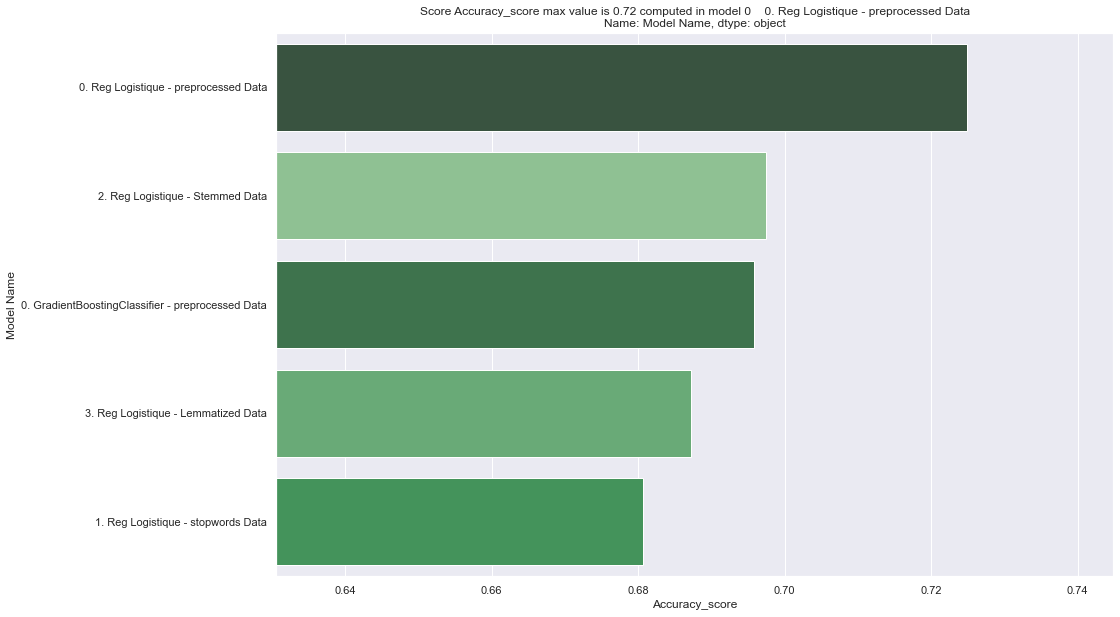

In [61]:
plot_model_result(store_score.sort_values(by=['Accuracy_score'], ascending=False).head(5), "Accuracy_score", "Model Name")


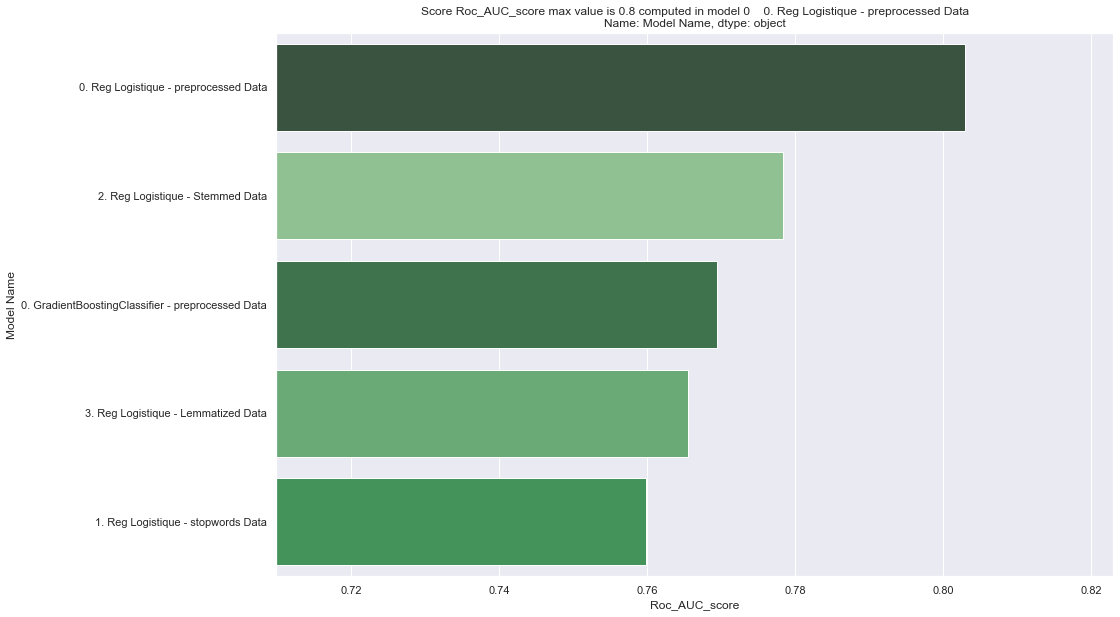

In [66]:
plot_model_result(store_score.sort_values(by=['Accuracy_score'], ascending=False).head(5), "Roc_AUC_score", "Model Name")


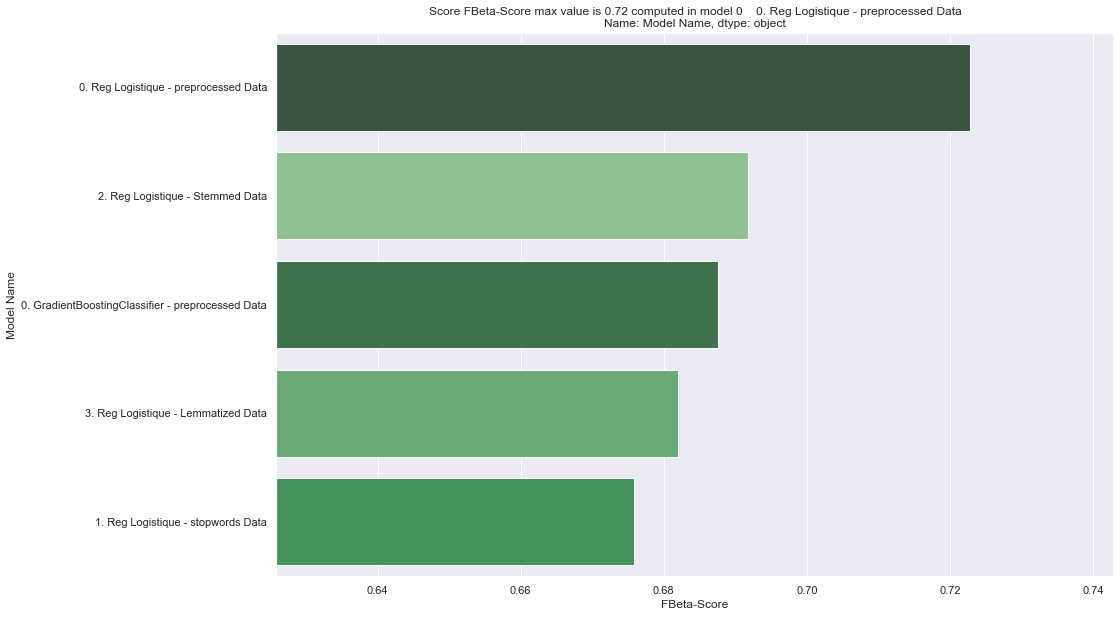

In [65]:
plot_model_result(store_score.sort_values(by=['Accuracy_score'], ascending=False).head(5), "FBeta-Score", "Model Name")


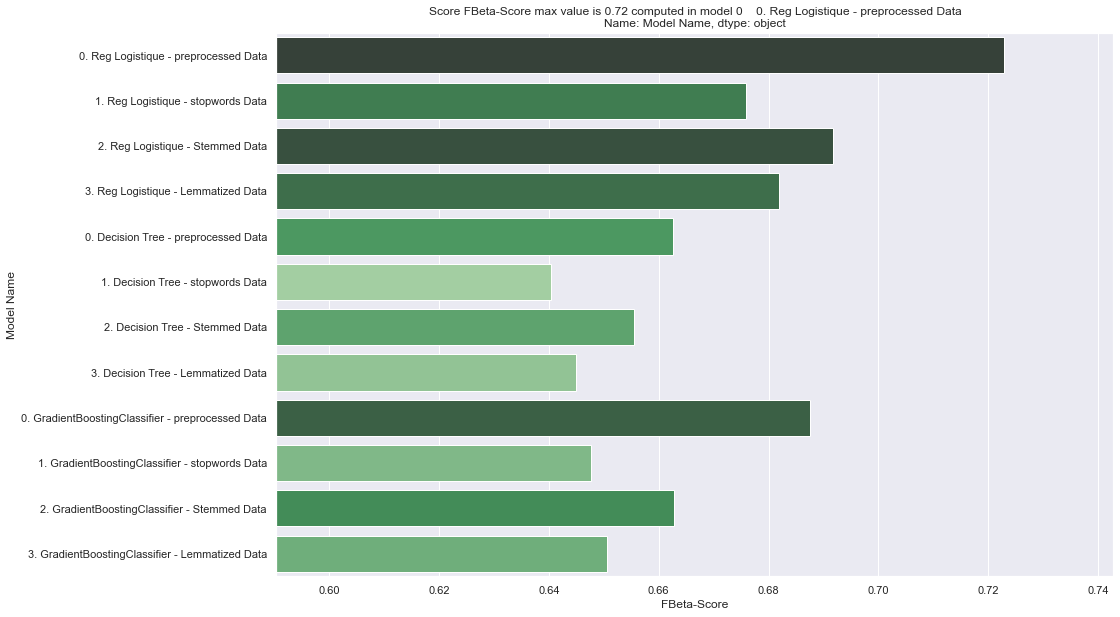

In [62]:
plot_model_result(store_score, "FBeta-Score", "Model Name")

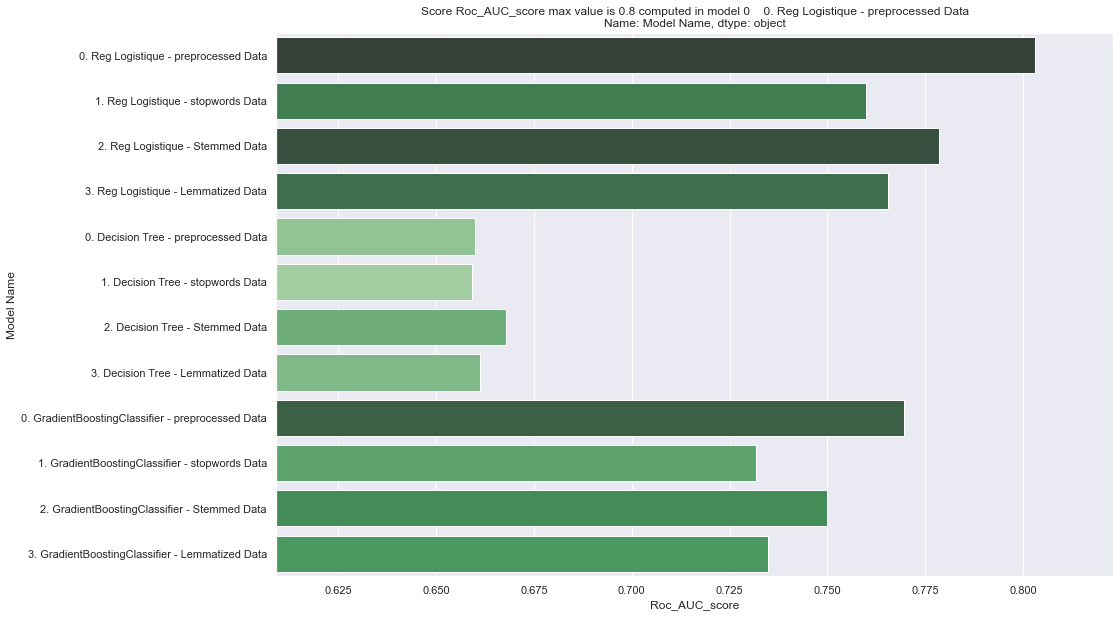

In [67]:
plot_model_result(store_score, "Roc_AUC_score", "Model Name")

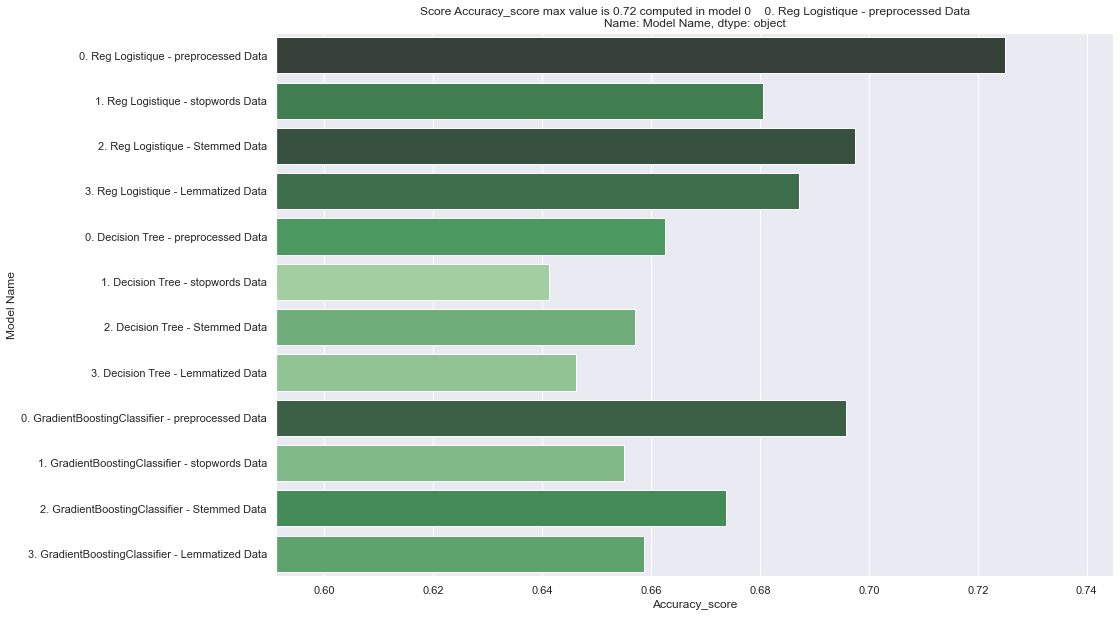

In [64]:
plot_model_result(store_score, "Accuracy_score", "Model Name")


## Amélioration des modèles supervisés

### Recherche des HyperParamètres sur les Modèles supervisés ==> Objectif: Améliorer le ROC_AUC
La première étape est d'effectuer une recherche des hyper parametres, et nous utiliserons la **fonction GridSearchCV** ([Voir Doc SickitLearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html))
Nous veillerons spécifiquement à l'utilisation des parametres ([voir explications du TP Openclassrooms](https://openclassrooms.com/fr/courses/4297211-evaluez-les-performances-dun-modele-de-machine-learning/4308246-tp-selectionnez-le-nombre-de-voisins-dans-un-knn#/id/r-4334066))
 - **n_jobs**: Nombre de jobs qui tourne en parallèle (-1 = Tous les processeurs actifs)
 - **scoring** : Utilisation de la valeur [F_Beta](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html) determinér à l'aide de la fonctiopn [make_scorer](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html)
 - **param_grid** : Dictionnaire des paramètres à évaluer

Voici egalement quelques sources intérressantes :
 - [model hyperparameters are set by the data scientist ahead of training and control implementation aspects of the model](https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search)
 - [Source Wikipedia](https://en.wikipedia.org/wiki/Hyperparameter_optimization)
 - [What is the Difference Between a Parameter and a Hyperparameter?](https://machinelearningmastery.com/difference-between-a-parameter-and-a-hyperparameter/)



In [29]:
#Ré-initialisation de la table des résultats
# score_column_names = ["Model Type","Model Name","seuil","F1-Score","FBeta-Score", "Recall_score", "Precision_score", "Accuracy_score", "Roc_AUC_score"]
# store_score = pd.DataFrame(columns = score_column_names)

In [71]:
#grid_values = {"C":np.logspace(-3,3,7), "penalty":['l1','l2']}
grid_values = {"C":np.logspace(-5,5,15), "penalty":['l2']}
#grid_values = {'penalty' : ['l1','l2'], 'C' : np.logspace(-3,3,7), 'solver' : ['newton-cg', 'lbfgs', 'liblinear']}

f1 = make_scorer(f1_score,average = 'binary') #, pos_label=4
accuracy = make_scorer(accuracy_score)
fbeta = make_scorer(fbeta_score, beta = 0.5,average = 'binary') #, pos_label=4

logistic_reg_2 = LogisticRegression(random_state=0)
logistic_reg_2_cv = GridSearchCV(logistic_reg_2, 
                                 param_grid=grid_values,
                                 scoring=accuracy,
                                 cv=5, #Possibly value 
                                 n_jobs=-1,
                                 error_score='raise'
                                )
#Train the gridSearchCV
logistic_reg_2_cv.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",logistic_reg_2_cv.best_params_)
print("Accuracy_score :",logistic_reg_2_cv.best_score_)

#converting the logistic_reg_2_cv.cv_results to dataframe
df=pd.DataFrame.from_dict(logistic_reg_2_cv.cv_results_)
df['Accuracy_score']=(df['split0_test_score']+df['split1_test_score'])/2
df.loc[df['Accuracy_score'] == df['Accuracy_score'].max(), 'params']



tuned hpyerparameters :(best parameters)  {'C': 138.9495494373139, 'penalty': 'l2'}
Accuracy_score : 0.7265364583333334


7    {'C': 1.0, 'penalty': 'l2'}
Name: params, dtype: object

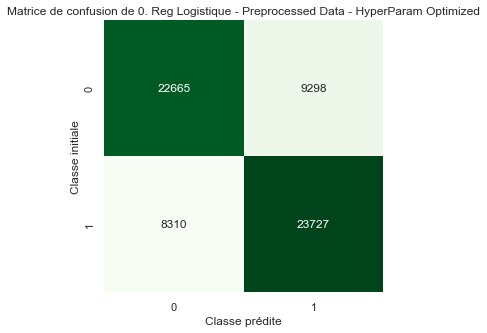

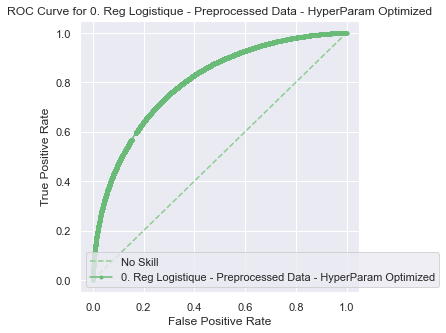

In [73]:
#Train the classifier using best parameters identified during GridSearchCV
logistic_reg_2_hyper_params = LogisticRegression(**logistic_reg_2_cv.best_params_, random_state=0)
logistic_reg_2_hyper_params.fit(X_train, y_train)

seuil=0.5
model_name="0. Reg Logistique - Preprocessed Data - HyperParam Optimized"
score_results_stored = evaluation(logistic_reg_2_hyper_params, model_name, score_column_names, X_test, y_test,seuil = 0.5, binary_predict=False, predict_proba_OK=True)

store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)

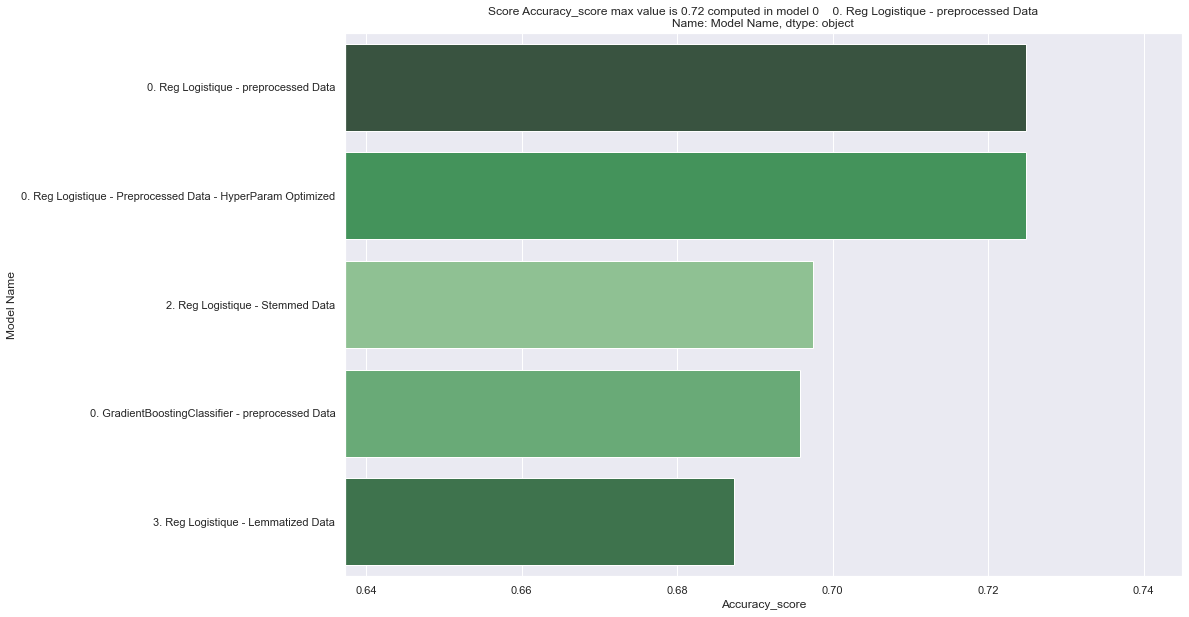

In [80]:
plot_model_result(store_score.sort_values(by=['Accuracy_score'], ascending=False).head(5), "Accuracy_score", "Model Name")


In [79]:
store_score.sort_values(by=['Accuracy_score'], ascending=False).head(5)

,Model Type,Model Name,seuil,F1-Score,FBeta-Score,Recall_score,Precision_score,Accuracy_score,Roc_AUC_score
0,LogisticRegression(random_state=0),0. Reg Logistique - preprocessed Data,0.5,0.729313,0.722859,0.740331,0.718618,0.724906,0.803053
13,"LogisticRegression(C=138.9495494373139, random...",0. Reg Logistique - Preprocessed Data - HyperP...,0.5,0.729366,0.72278,0.740612,0.718456,0.724875,0.803056
2,LogisticRegression(random_state=0),2. Reg Logistique - Stemmed Data,0.5,0.714153,0.691777,0.754846,0.677623,0.697516,0.7784
8,([DecisionTreeRegressor(criterion='friedman_ms...,0. GradientBoostingClassifier - preprocessed Data,0.5,0.720059,0.68765,0.78144,0.667618,0.695844,0.769528
3,LogisticRegression(random_state=0),3. Reg Logistique - Lemmatized Data,0.5,0.705915,0.681941,0.749852,0.666842,0.68725,0.765572


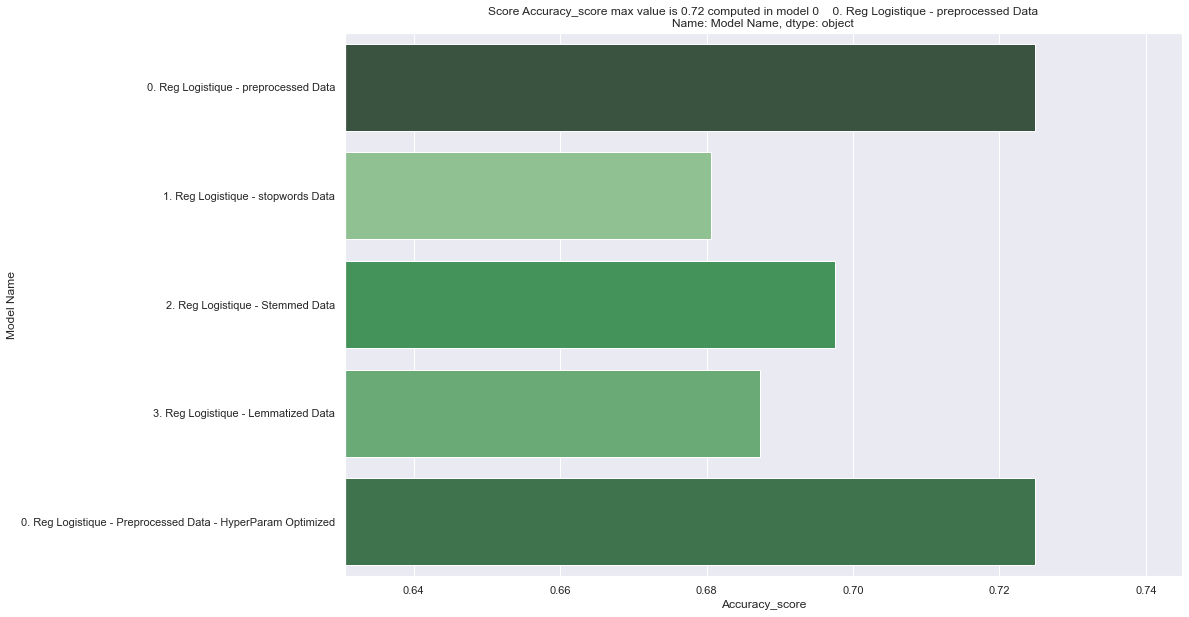

In [81]:
plot_model_result(store_score[store_score['Model Name'].str.contains("Reg Logistique")], "Accuracy_score", "Model Name")


### Retouche du BoW

In [34]:
#STEM TEXT
#Define 20% of dataset as Test dataset
X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(clean_df['text_stem'], clean_df['target'], test_size=0.2, random_state=0, stratify=clean_df['target'])
#Define 20% (=25% * 80%) of dataset as Val dataset, and 60% as Train dataset
X_train_stem, X_val_stem, y_train_stem, y_val_stem = train_test_split(X_train_stem, y_train_stem, test_size=0.25, random_state=0, stratify=y_train_stem)

#For STEM TEXT
vectoriser_stem = TfidfVectorizer(min_df=0.001,max_df=0.8) #TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser_stem.fit(X_train_stem)
print(f'vectoriser_stem entrainé, et le nombre de feature est de {len(vectoriser_stem.get_feature_names_out())}')


#For STEM TEXT
X_train_stem = vectoriser_stem.transform(X_train_stem)
X_val_stem = vectoriser_stem.transform(X_val_stem)
X_test_stem  = vectoriser_stem.transform(X_test_stem)
print("La Matrice TF-IDF normalisée %d X %d à partir du text X_train_stem" % (X_train_stem.shape[0], X_train_stem.shape[1]) )
print("La Matrice TF-IDF normalisée %d X %d à partir du text X_val_stem" % (X_val_stem.shape[0], X_val_stem.shape[1]) )
print("La Matrice TF-IDF normalisée %d X %d à partir du text X_test_stem" % (X_test_stem.shape[0], X_test_stem.shape[1]) )



vectoriser_stem entrainé, et le nombre de feature est de 978
La Matrice TF-IDF normalisée 192000 X 978 à partir du text X_train_stem
La Matrice TF-IDF normalisée 64000 X 978 à partir du text X_val_stem
La Matrice TF-IDF normalisée 64000 X 978 à partir du text X_test_stem


In [35]:
#grid_values = {"C":np.logspace(-3,3,7), "penalty":['l1','l2']}
grid_values = {"C":np.logspace(-5,5,15), "penalty":['l2']}
#grid_values = {'penalty' : ['l1','l2'], 'C' : np.logspace(-3,3,7), 'solver' : ['newton-cg', 'lbfgs', 'liblinear']}

f1 = make_scorer(f1_score,average = 'binary') #, pos_label=4
accuracy = make_scorer(accuracy_score)
fbeta = make_scorer(fbeta_score, beta = 0.5,average = 'binary') #, pos_label=4

logistic_reg_2 = LogisticRegression(random_state=0)
logistic_reg_2_cv = GridSearchCV(logistic_reg_2, 
                                 param_grid=grid_values,
                                 scoring=accuracy,
                                 cv=5, #Possibly value 
                                 n_jobs=-1,
                                 error_score='raise'
                                )
#Train the gridSearchCV
logistic_reg_2_cv.fit(X_train_stem, y_train_stem)

print("tuned hpyerparameters :(best parameters) ",logistic_reg_2_cv.best_params_)
print("FBeta_Score :",logistic_reg_2_cv.best_score_)

#converting the logistic_reg_2_cv.cv_results to dataframe
df=pd.DataFrame.from_dict(logistic_reg_2_cv.cv_results_)
df['Accuracy_score']=(df['split0_test_score']+df['split1_test_score'])/2
df.loc[df['Accuracy_score'] == df['Accuracy_score'].max(), 'params']

# model_name_2="2. Reg Logistique - Stemmed Data"
# logistic_reg_2 = LogisticRegression(random_state=0)
# logistic_reg_2.fit(X_train_stem, y_train_stem)
# evaluation(logistic_reg_2, model_name_2, score_column_names, X_test_stem, y_test_stem,seuil)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2'}
FBeta_Score : 0.7463437500000001


7    {'C': 1.0, 'penalty': 'l2'}
Name: params, dtype: object

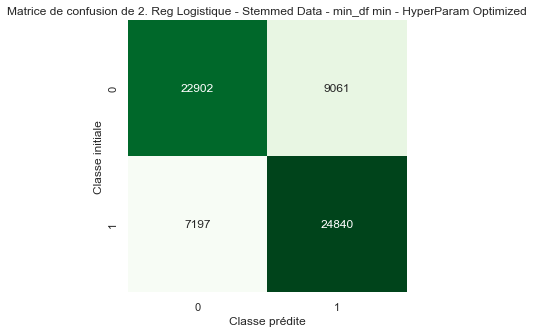

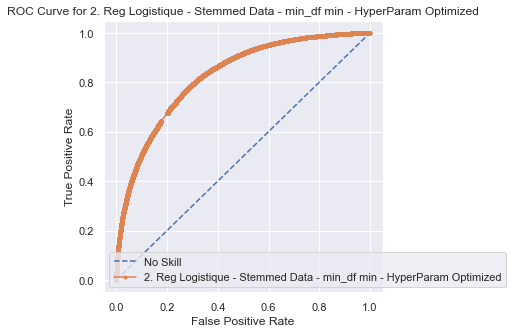

In [36]:
#Train the classifier using best parameters identified during GridSearchCV
logistic_reg_2_min_df_hyper_params = LogisticRegression(**logistic_reg_2_cv.best_params_, random_state=0)
logistic_reg_2_min_df_hyper_params.fit(X_train_stem, y_train_stem)

seuil=0.5
model_name="2. Reg Logistique - Stemmed Data - min_df min - HyperParam Optimized"
score_results_stored = evaluation(logistic_reg_2_min_df_hyper_params, model_name, score_column_names, X_test_stem, y_test_stem,seuil = 0.5, binary_predict=False, predict_proba_OK=True)

store_score = pd.concat([store_score, score_results_stored], axis=0, ignore_index=True)

Nous voyons ici que la retouche du BoW permet d'augmenter le nombre de features (diminution du min_df), et cela améliore fortement les performances du modèle:

 - le ROC_AUC est donc de 0.82.
 - le FBeta score est de 0.74.
 - l'Accuracy est de 0.74

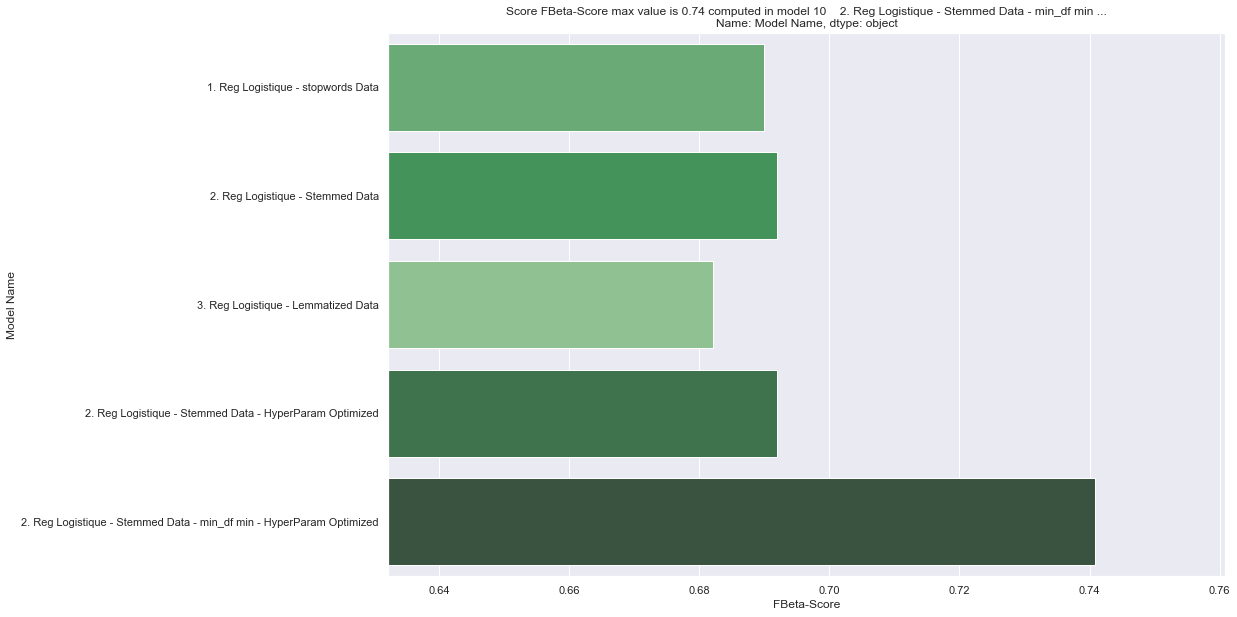

In [37]:
plot_model_result(store_score[store_score['Model Name'].str.contains("Reg Logistique")], "FBeta-Score", "Model Name")


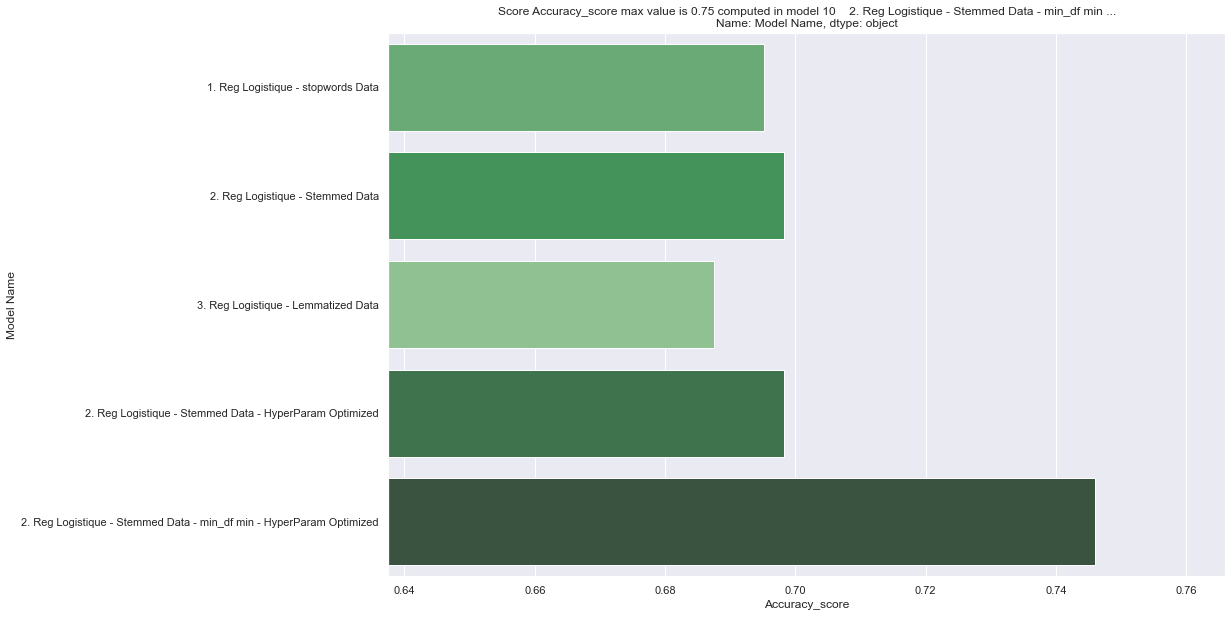

In [38]:
plot_model_result(store_score[store_score['Model Name'].str.contains("Reg Logistique")], "Accuracy_score", "Model Name")


## Save Models and Vectorisers

In [39]:
file = open('./Models/vectoriser-stem.pickle','wb')
pickle.dump(vectoriser_stem, file)
file.close()
#save vectoriser_stem model in joblib files
dump(vectoriser_stem, './Models/vectoriser_stem.joblib')

file = open('./Models/Sentiment-RegLog_Stem.pickle','wb')
pickle.dump(logistic_reg_2_min_df_hyper_params, file)
file.close()
#save GBoost_clf_2_hyper_params model in joblib files
dump(logistic_reg_2_min_df_hyper_params, './Models/Sentiment-RegLog_Stem.joblib')

# file = open('./Models/Sentiment-GradientBoosting_Stem.pickle','wb')
# pickle.dump(GBoost_clf_2_hyper_params, file)
# file.close()
# #save GBoost_clf_2_hyper_params model in joblib files
# dump(GBoost_clf_2_hyper_params, './Models/GBoost_clf_2_hyper_params.joblib')

['./Models/Sentiment-RegLog_Stem.joblib']

## TO-DO List

- [x] Text processing = Pipeline
- [x] Matrice TF-IDF = Optimisé à l'aide de min_df (938 variables conservés)
- [x] Regressions (Reg Log, DecisionTree, Gradient Boost)
- [x] Score FBeta pour la mesure de la perf
- [x] GridSearchCV pour l'optimisation des Hyperparam
- [x] Visualisation des résultats
- [x] Stockage des modèles